# Analysis of residues per cavity
This notebook details the statistic calculations performed in order to obtain the necessary approximations to the PDF for the data distributions of the residues surrounding the cavity.

In [ ]:
# import necessary libraries
import json
import copy
import pandas as pd
from scipy.stats import shapiro
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import scipy.optimize as optimize
import statsmodels.api as sm
%matplotlib inline

: 

## 1. Loading data and transforming it into proportions per cavity
The first step will be transform a list of lists of residues per cavity into a dictionary of proportion of residues per cavity. These residues will be organised by the biochemical nature in the following groups:

- **Aromatic:** Phe, Tyr, and Trp
- **Polar:** Tyr, Thr, Ser, Cys, Met, Asn, Gln, and His
- **Positive:** His, Lys, and Arg
- **Negative:** Asp and Glu
- **Hidrophobic:** Phe, Trp, Ala, Val, Leu, Ile, and Pro
- **Large chain:** Phe, Tyr, Trp, Met, Gln, Glu, Arg, Lys, His, Leu, and Ile

In [2]:
# Load data
with open('residues.json') as json_reader:
    data = json.load(json_reader)

# Define each residue group
chemical_nature = {
    'aromatic': {'PHE', 'TYR', 'TRP'},
    'polar': {'TYR', 'THR', 'SER', 'CYS', 'MET', 'ASN', 'GLN', 'HIS'},
    'positive': {'HIS', 'LYS', 'ARG'},
    'negative': {'ASP', 'GLU'},
    'hidrophobic': {'PHE', 'TRP', 'ALA', 'VAL', 'LEU', 'ILE', 'PRO'},
    'large_chain': {'PHE', 'TYR', 'TRP', 'MET', 'GLN', 'GLU', 'ARG', 'LYS', 'HIS', 'LEU', 'ILE'}
}

# Count residues per site
sites = []

for entry in data:
    site = {
        'aromatic': 0,
        'polar':  0,
        'positive': 0,
        'negative': 0,
        'hidrophobic': 0,
        'large_chain': 0
    }
    total = len(entry)
    for element in entry:
        for key, value in chemical_nature.items():
            if element in value:
                site[key] += 1 / total
    sites.append(site)
sites_df = pd.DataFrame(sites)

## 2. Exploration of data distributions per chemical nature
The second step will be to perform a series of exploratory analyses in order to get a better understanding on how the data are distributed.

### 2.1. Basic statistical measurements

In [3]:
# Calculating basic statistics
single_statistics = {
    'mean': 0,
    'median': 0,
    'std': 0,
    'kurtosis': 0
}
all_stats = {
    'aromatic': 0,
    'polar':  0,
    'positive': 0,
    'negative': 0,
    'hidrophobic': 0,
    'large_chain': 0
}

for key in all_stats.keys():
    all_stats[key] = copy.deepcopy(single_statistics)

    all_stats[key]['mean'] = sites_df[key].mean()
    all_stats[key]['median'] = sites_df[key].median()
    all_stats[key]['std'] = sites_df[key].std()
    all_stats[key]['kurtosis'] = sites_df[key].kurtosis()

for key in all_stats.keys():
    print(f'{key}:')
    for subkey, value in all_stats[key].items():
        print(f'\t{subkey} = {value}')


aromatic:
	mean = 0.14184408925336442
	median = 0.13636363636363635
	std = 0.06969321829193242
	kurtosis = -0.20091985857285355
polar:
	mean = 0.3521079713147782
	median = 0.3333333333333333
	std = 0.11354682612431237
	kurtosis = 0.564932146441127
positive:
	mean = 0.14145476758056172
	median = 0.125
	std = 0.06697344318246501
	kurtosis = 0.7689461667724529
negative:
	mean = 0.039727440787526734
	median = 0.034482758620689655
	std = 0.03923434787856143
	kurtosis = 1.4051864330012265
hidrophobic:
	mean = 0.5332140714239383
	median = 0.5483870967741933
	std = 0.13364973863821972
	kurtosis = 0.20857608825554808
large_chain:
	mean = 0.5918559325749089
	median = 0.5945945945945945
	std = 0.10095493849971328
	kurtosis = 0.6404106968915864


There seems to be quite a dispersion on the values as showed by the std values when compared with the mean or median. This result seems to be supported by the kurtosis values (kurtosis = 0 is a sign of normality). However, the normality or lack thereof of the distribution would need to be formally demonstrated by either Shapiro-Wilkson test or Kolmogorov-Smirnov test (the difference between them, right now eludes me, but should not be all that difficult to check). In any case, the visual representation of the distributions should better illustrate (lame pun), the shape of the distributions. 

### 2.2. Graphical representation of data distributions

#### 2.2.1. Aromatic  residues

Text(0.5, 1.0, 'Aromatic Residues')

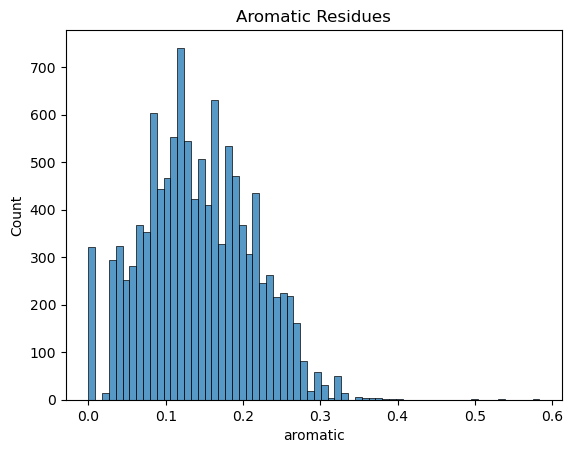

In [4]:
sns.histplot(sites_df['aromatic'])
plt.title('Aromatic Residues')

Seems to have a normal enough shape, we will perform shapiro-wilk test.

In [5]:
# Shapiro-Wilks normality test
shapiro(sites_df['aromatic'])

/home/rfernandez/miniconda3/envs/brigit/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9897292852401733, pvalue=4.945436133489085e-28)

The null hypothesis is that the data follows a normal distribution. We have to reject this hypothesis due to the p-value being way lower than 0.05, so it is not normal.

## 2.3. PDF approximation by bimodal function

Now, we will approximate the Probability Density Function (PDF) of the data distributions with a bimodal (double gaussian) distribution. To adjust the histograms to the function, we first create a smooth distribution using Kernel Density Estimation (KDE) with gaussian kernel and then adjust the bimodal function to this approximation using non-linear least squares adjustement with the Levenverg-Marquadt algorithm.

In [26]:
# Definition of bimodal distribution
def _normpdf(x: np.array or float, nu: float, std: float):
    """
    Helper function for `bimodal`, computes the PDF of a
    gaussian function.
    Args:
        x (np.array or float): Set of input values to evaluate.
        nu (float): Average value for the gaussian.
        std (float): Standard deviation of the gaussian.
    Returns:
        result (float): PDF value.
    """

    var = std ** 2
    num = np.exp(- (x - nu) ** 2 / (2 * var))
    return num

def bimodal(
    x: np.array,
    chi1: float,
    nu1: float,
    sigma1: float,
    chi2: float,
    nu2: float,
    sigma2: float
):
    first_gaussian = _normpdf(x, nu1, sigma1)
    second_gaussian = _normpdf(x, nu2, sigma2)
    return chi1 * first_gaussian + chi2 * second_gaussian


# Definition of the training function
def adjust(
    data: pd.DataFrame,
    res_family: str,
    p0: list,
    data_path: str
):
    res_data = data[res_family]

    # Histogram for plot later on
    hist, bins = np.histogram(res_data)
    hist = (hist - hist.min()) / (hist.max() - hist.min())

    # Approximation of KDE
    dens = sm.nonparametric.KDEMultivariate(data=res_data, var_type='c')
    x = np.linspace(0, res_data.max(), 1024)
    y = dens.pdf(x)
    y = ((y - y.min()) / (y.max() - y.min()))

    # Adjustment of bimodal function
    popt, pcov = optimize.curve_fit(
        f=bimodal,
        xdata=x,
        ydata=y,
        p0=p0,
        method='lm',
        maxfev=int(10e3)
    )

    # Calculation of R^2
    y_gaussian = bimodal(x, *popt)
    residuals = y - y_gaussian
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot
    plt.title(f'{res_family} R^2 = {round(r_squared, 3)}; n = {len(res_data)}')
    plt.stairs(hist, bins)
    plt.plot(x, y_gaussian)
    plt.legend(['Real', 'Approximate PDF'])
    plt.legend(['Real', 'Approximate PDF'])
    plt.savefig(f'{res_family}.png')
    plt.show()

    with open(data_path, 'r') as reader:
        output = json.load(reader)
        output[res_family] = popt.tolist()
    with open(data_path, 'w') as writer:
        json.dump(output, writer, indent=4, sort_keys=True)

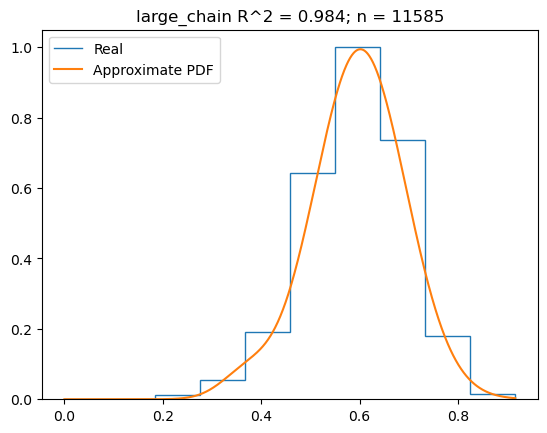

In [47]:
adjust(sites_df, 'large_chain', [1, 0.6, .1, 0., 0.1, .1], './residue_stats.json')